### Importing the dependencies

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import plotly.express as px

# For dealing with textual data
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,MinMaxScaler,StandardScaler
import warnings

# Ignore the warning
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Loading the data from csv file
df = pd.read_csv('../Dataset/glassdoor_jobs.csv')

### Exploratory data analysis

In [3]:
df.sample(3)

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
126,126,Data Scientist,$83K-$144K (Glassdoor est.),Job Description\n\n\nTakeda is looking for a D...,3.7,Takeda Pharmaceuticals\n3.7,"Cambridge, MA","OSAKA, Japan",10000+ employees,1781,Company - Public,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,$10+ billion (USD),"Novartis, Baxter, Pfizer"
32,32,Data Scientist,$72K-$120K (Glassdoor est.),Preferred Qualifications\nMasters degree or do...,3.6,Amrock\n3.6,"Detroit, MI","Detroit, MI",1001 to 5000 employees,1997,Company - Private,Real Estate,Real Estate,$500 million to $1 billion (USD),-1
17,17,Customer Data Scientist,$118K-$189K (Glassdoor est.),Company Overview\n\nH2O.ai is the open source ...,4.3,h2o.ai\n4.3,"Mountain View, CA","Mountain View, CA",201 to 500 employees,2011,Company - Private,Enterprise Software & Network Solutions,Information Technology,Unknown / Non-Applicable,-1


Let's write the things which I think needs to be done from the very first glance of the dataset
- Extract the salary numerical values and create new feature with average salary value
- Extract the company name from given format of {company/rating}
- Remocal of unnecessary features such Unnamed 0,Competitors,Headquarters,Rating -> Because rating is done on what basis

In [4]:
# Removing the unnecessary feature
df.drop(['Unnamed: 0','Competitors','Headquarters','Rating'],axis=1,inplace=True)

In [5]:
# Storing the indexes of the rows having per hour amount mentioned
indices = []
for index, row in df.iterrows():
    if 'Per Hour' in row['Salary Estimate']:  
        indices.append(index)

# Removing the rows 
df = df.drop(indices)
df.reset_index(drop=True,inplace=True)

In [6]:
diff_format_indices = []
for idx,row in df.iterrows():
    if 'Provided' in row['Salary Estimate']:
        diff_format_indices.append(idx)

set_diff_format_indices = set(diff_format_indices)

In [7]:
avg_salary = []

for index, row in df.iterrows():
    salary_data_yearly = row['Salary Estimate']
    
    if salary_data_yearly != str(-1):

        if index not in set_diff_format_indices:
            lower_raw, upper_raw = salary_data_yearly.split('(')[0].split('-')
            lower_value, upper_value = np.int64(lower_raw[1:-1]), np.int64(upper_raw[1:-2])
            avg_salary.append(np.mean([lower_value, upper_value]))  
        else:

            # Using different extraction for the per hour instances
            lower_raw, upper_raw = salary_data_yearly.split(':')[1].split('-')
            lower_value, upper_value = np.int64(lower_raw[1:-1]), np.int64(upper_raw[1:-1])
            avg_salary.append(np.mean([lower_value, upper_value]))  
    else:
        avg_salary.append(-1)

# Adding a new feature
df['Avg_salary'] = avg_salary
df.drop(['Salary Estimate'],axis=1,inplace=True)

#### Cleaning the compnay name feature

In [8]:
company_name = []

for index, row in df.iterrows():
    item = row['Company Name'].split('\n')[0]
    company_name.append(item) 

df['company_name'] = company_name
df.drop(['Company Name'],axis=1,inplace=True)

#### Cleaning the job description feature

In [9]:
def process_jd(text):
    """
    Clean and preprocess a job description text.

    Parameters:
        text (str): The job description text to be processed.

    Returns:
        str: The cleaned and preprocessed job description text.

    Steps:
        1. Replaces newline characters ('\n') with spaces.
        2. Converts the text to lowercase.
        3. Removes punctuation.
        4. Removes English stop words.
        5. Lemmatizes the remaining words.
    """
    # Replacing \n with ' '
    text = text.replace('\n', ' ')
    
    # Lowercasing
    text_lower = text.lower()
    
    # Removing punctuation
    text_no_punctuation = text_lower.translate(str.maketrans('', '', string.punctuation))
    
    # Removing stop words
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text_no_punctuation)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    
    # Lemmatization
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]
    
    clean_text = ' '.join(lemmatized_text)    
    return clean_text

In [10]:
# Creating new feature for the clean job description and also removing the old feature
df['jd'] = df['Job Description'].map(process_jd)
df.drop(['Job Description'],axis=1,inplace=True)

#### Extracting the age of company

In [11]:
company_founding_years = {
    'The Church of Jesus Christ of Latter-day Saints': 1830,
    'Numeric, LLC': 2006,
    'Kronos Bio': 2017,
    'Teasdale Latin Foods': 1942,
    'Decode_M': 2018,
    'Cerus Corporation': 1991,
    'P2 Energy Solutions': 1999,
    'BPA Services': 2003,
    'Meridian Technologies, Inc': 1999,
    'Cuboid IT Solutions': 2010,
    'Seen by Indeed': 2018,
    'Karyopharm Therapeutics Inc.': 2008,
    'UPM Pharmaceutical Inc': 2004,
    'F&G': 1959,
    'Homology Medicines, Inc.': 2015,
    'Applied Research Laboratories': 1946,
    'OneThree Biotech': 2019,
    'Serigor Inc.': 2014,
    'CareDx': 1998,
    'CompuForce': 1982,
    'ALIN': 2003,
    'e-IT Professionals Corp.': 2003,
    'Watchful': 2020,
    'Conch Technologies, Inc': 2003,
    'Maxar Technologies': 1969,
    'Charter Spectrum': 2016, 
    'Two95 International Inc.': 1997,
    'Edison Software, Inc.': 2009,
    'Lorven Technologies Inc': 2006,
    'Persivia': 2014,
    'Delphi-US': 1998,
    'Muso': 2010,
    'Randstad': 2008, 
}

for comp in company_founding_years:
    df.loc[df['company_name'] == comp, 'Founded'] = company_founding_years[comp]

In [12]:
# Replacing the year founded with age of company and keeping -1 as they are
for i in range(len(df)):
    item = df.at[i, 'Founded']
    if item != -1:
        df.at[i, 'Founded'] = 2024 - item

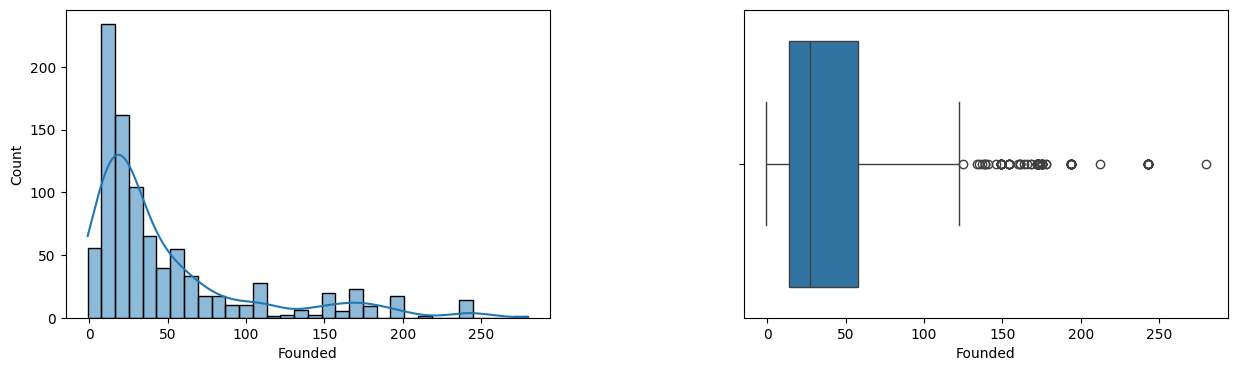

In [13]:
fig, ax = plt.subplots(1, 2, figsize=[15, 4])

# Plotting histogram
sns.histplot(x=df['Founded'], kde=True, ax=ax[0])

# Plotting boxplot
sns.boxplot(x=df['Founded'], ax=ax[1])

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          932 non-null    object 
 1   Location           932 non-null    object 
 2   Size               932 non-null    object 
 3   Founded            932 non-null    int64  
 4   Type of ownership  932 non-null    object 
 5   Industry           932 non-null    object 
 6   Sector             932 non-null    object 
 7   Revenue            932 non-null    object 
 8   Avg_salary         932 non-null    float64
 9   company_name       932 non-null    object 
 10  jd                 932 non-null    object 
dtypes: float64(1), int64(1), object(9)
memory usage: 80.2+ KB


In [15]:
founded_period = []

for i in range(len(df)):
    item = df.iloc[i]['Founded']
    if 0 < item < 50:
        founded_period.append('0-50')
    elif 50 <= item <= 100:
        founded_period.append('50-100')
    else:
        founded_period.append('More than 100')

# Convert 'Founded' column to string type
df['founded_period'] = founded_period
df.drop(['Founded'],axis=1,inplace=True)

#### Fixing the sector feature by finding the sector for the instances having -1

The key difference between `"industry"` and `"sector"` is that "industry" categorizes businesses based on the specific goods or services they produce, while "sector" categorizes businesses into broader groupings based on the nature of their economic activity and target markets.

- For instances having sector = -1, look for their job title and then replace the sector with the most frequent of sector for that job title

In [19]:
# Lowercasing for reducing any redundancy (Scientist = scientist)
cols = ['Job Title','Type of ownership','Industry','Sector']
for col in cols:
    df[col] = df[col].str.lower()

In [20]:
# From all the instances having no sector mentioned retrieving the instances having data related job profiles
data_jobs_indices = []
for index, row in df.iterrows():
    sector = row['Sector']
    if sector == str(-1):
        if 'data' in row['Job Title']:
            data_jobs_indices.append(index)

# Storing all the unique 
job_profiles = df.iloc[data_jobs_indices]['Job Title'].value_counts().index

In [21]:
data_jp_sector_dict = {}

# For each of the job profile retrieving the most frquent sector
for jp in job_profiles:
    sector_most_frequent = df[df['Job Title'] == jp]['Sector'].mode()[0]
    data_jp_sector_dict[jp] = sector_most_frequent

In [22]:
data_jp_sector_dict

{'data scientist': 'information technology',
 'data science manager': '-1',
 'big data engineer': '-1',
 'lead data engineer': 'information technology',
 'data engineer': 'information technology',
 'senior data scientist': 'information technology',
 'data operations lead': '-1'}

We can see that for almost all the data related job titles the sector is information technology so we will use this to fill the -1 values

In [23]:
# Replacing -1 sector value with information technology for all data related job titles 
for index in data_jobs_indices:
    df.loc[index, 'Sector'] = 'information technology'

In [24]:
remaining_job_titles = df[df['Sector'] == str(-1)]['Job Title'].value_counts().index
remaining_job_titles

Index(['research scientist, immunology - cancer biology',
       'scientist – cancer drug discovery',
       'scientist, upstream process development (bioreactors)',
       'senior scientist, cell pharmacology/assay development',
       'scientist - analytical development - pharmaceutics',
       'postdoc scientist - t cell engineering', 'environmental scientist',
       'scientist – cancer discovery, molecular assay',
       'principal research scientist/team lead, medicinal chemistry - oncology'],
      dtype='object', name='Job Title')

`Healthcare`

'senior scientist, cell pharmacology/assay development'
'environmental scientist'

`Biotech and Pharma`

'research scientist, immunology - cancer biology'
'scientist – cancer drug discovery'
'scientist, upstream process development (bioreactors)'
'scientist - analytical development - pharmaceutics'
'postdoc scientist - T cell engineering'
'scientist – cancer discovery, molecular assay'
'principal research scientist/team lead, medicinal chemistry - oncology'

In [25]:
health_jt = ['senior scientist, cell pharmacology/assay development', 'environmental scientist']
biotech_jt = ['research scientist, immunology - cancer biology',
              'scientist – cancer drug discovery',
              'scientist, upstream process development (bioreactors)',
              'scientist - analytical development - pharmaceutics',
              'postdoc scientist - t cell engineering',
              'scientist – cancer discovery, molecular assay',
              'principal research scientist/team lead, medicinal chemistry - oncology']

# Assuming df is your DataFrame with columns 'Job Title' and 'Sector'
for h_jt in health_jt:
    df.loc[(df['Job Title'] == h_jt) & (df['Sector'] == '-1'), 'Sector'] = 'health care'

for b_jt in biotech_jt:
    df.loc[(df['Job Title'] == b_jt) & (df['Sector'] == '-1'), 'Sector'] = 'biotech & pharmaceuticals'

#### Fixing the industry feature

In [26]:
# From all the instances having no sector mentioned retrieving the instances having data related job profiles
data_jobs_indices = []
for index, row in df.iterrows():
    sector = row['Industry']
    if sector == str(-1):
        if 'data' in row['Job Title']:
            data_jobs_indices.append(index)

# Storing all the unique 
job_profiles = df.iloc[data_jobs_indices]['Job Title'].value_counts().index

In [27]:
data_jp_industry_dict = {}

# For each of the job profile retrieving the most frquent sector
for jp in job_profiles:
    sector_most_frequent = df[df['Job Title'] == jp]['Industry'].mode()[0]
    data_jp_industry_dict[jp] = sector_most_frequent

In [28]:
# Replacing -1 sector value with information technology for all data related job titles 
for index in data_jobs_indices:
    df.loc[index, 'Industry'] = 'it services'

In [29]:
remaining_job_titles = df[df['Industry'] == str(-1)]['Job Title'].value_counts().index
remaining_job_titles

Index(['research scientist, immunology - cancer biology',
       'scientist – cancer drug discovery',
       'scientist, upstream process development (bioreactors)',
       'senior scientist, cell pharmacology/assay development',
       'scientist - analytical development - pharmaceutics',
       'postdoc scientist - t cell engineering', 'environmental scientist',
       'scientist – cancer discovery, molecular assay',
       'principal research scientist/team lead, medicinal chemistry - oncology'],
      dtype='object', name='Job Title')

In [30]:
for h_jt in health_jt:
    df.loc[(df['Job Title'] == h_jt) & (df['Industry'] == '-1'), 'Industry'] = 'health care services & hospitals'

for b_jt in biotech_jt:
    df.loc[(df['Job Title'] == b_jt) & (df['Industry'] == '-1'), 'Industry'] = 'biotech & pharmaceuticals'

#### Replacing the -1 in Size feature with `Unknown` feature

In [31]:
df['Size'] = df['Size'].replace('-1','Unknown')

#### Replacing the Unkown/Non-Appicable in Size feature with `Unknown` feature value

In [32]:
df['Revenue'] = df['Revenue'].replace('Unknown / Non-Applicable', 'Unknown')

Based on my analysis I have found that the companies which have either revenue or type of ownership feature value missing they also do not have any associated value for the Avg_salary so we will simply remove such rows from the dataframe.

In [33]:
rem_idx = df[(df['Revenue'] == str(-1)) | (df['Type of ownership'] == str(-1))].index
df.drop(rem_idx,axis=0,inplace=True)

## Train test split
For doing train test split we will be using 80% data for training and remaining 20% for testing.Now since there are 204 instances for which there are no associated target variable values so we will be using all those instances as the testing data and remaining ones for the training

In [34]:
# Identify indices of instances with missing target values
indexes_avg_salary_nan = df[df['Avg_salary'] == -1].index

# Create a mask to select rows not in indexes_avg_salary_nan
mask_train = ~df.index.isin(indexes_avg_salary_nan)

# Use the mask to select rows for the training set
train_df = df[mask_train]

# Use the indices to select rows for the testing set
test_df = df.loc[indexes_avg_salary_nan]

## Data processing pipeline

- Target Encoding
    - Job title
    - Location
    - Type of ownership
    - industry
    - sector
    - company_name
    
- Ordinal encoding
    - Size
    - Revenue
    - founded_period
 
- Scaling : Target encoded and ordinal encoded values

- Embeddings : job description 

In [35]:
updated_order = ['Job Title', 'Location', 'Type of ownership','Industry', 'Sector','company_name',
                 'Size', 'founded_period', 'Revenue','jd','Avg_salary']

train_df = train_df[updated_order]

In [36]:
train_df.head(5)

,Job Title,Location,Type of ownership,Industry,Sector,company_name,Size,founded_period,Revenue,jd,Avg_salary
0,data scientist,"Albuquerque, NM",company - private,aerospace & defense,aerospace & defense,Tecolote Research,501 to 1000 employees,50-100,$50 to $100 million (USD),data scientist location albuquerque nm educati...,72.0
1,healthcare data scientist,"Linthicum, MD",other organization,health care services & hospitals,health care,University of Maryland Medical System,10000+ employees,0-50,$2 to $5 billion (USD),general summary healthcare data scientist posi...,87.5
2,data scientist,"Clearwater, FL",company - private,security services,business services,KnowBe4,501 to 1000 employees,0-50,$100 to $500 million (USD),knowbe4 inc high growth information security c...,85.0
3,data scientist,"Richland, WA",government,energy,"oil, gas, energy & utilities",PNNL,1001 to 5000 employees,50-100,$500 million to $1 billion (USD),organization job id job id 310709 directorate ...,76.5
4,data scientist,"New York, NY",company - private,advertising & marketing,business services,Affinity Solutions,51 to 200 employees,0-50,Unknown,data scientist affinity solution marketing clo...,114.5


In [38]:
df['Size'].value_counts().index

Index(['1001 to 5000 employees', '201 to 500 employees', '51 to 200 employees',
       '10000+ employees', '501 to 1000 employees', '5001 to 10000 employees',
       '1 to 50 employees', 'Unknown'],
      dtype='object', name='Size')

In [ ]:
# Column transformer for doing ordinal and nominal encoding
encoding_transformer = ColumnTransformer(transformers=[

    ('Encode_jt', ce.TargetEncoder(cols=['Job Title']), [0]),
    ('Encode_location', ce.TargetEncoder(cols=['Location']), [1]),
    ('Encode_ownership', ce.TargetEncoder(cols=['Type of ownership']), [2]),
    ('Encode_industry', ce.TargetEncoder(cols=['Industry']), [3]),
    ('Encode_sector', ce.TargetEncoder(cols=['Sector']), [4]),
    ('Encode_name', ce.TargetEncoder(cols=['company_name']), [5]),

    ('Encode_size', OrdinalEncoder(categories=[
        ['1 to 50 employees',
        '51 to 200 employees',
        '201 to 500 employees',
        '501 to 1000 employees',
        '1001 to 5000 employees',
        '5001 to 10000 employees',
        '10000+ employees',
        'Unknown']
    ], handle_unknown="use_encoded_value", unknown_value=np.nan), [6]),

    ('Encode_founded', OrdinalEncoder(categories=[
        ['0-50', '50-100', 'More than 100']
    ], handle_unknown="use_encoded_value", unknown_value=np.nan), [7]),

    ('Encode_revenue', OrdinalEncoder(categories=[
        ['Unknown', 'Less than $1 million (USD)',
        '$1 to $5 million (USD)',
        '$5 to $10 million (USD)',
        '$10 to $25 million (USD)',
        '$25 to $50 million (USD)',
        '$50 to $100 million (USD)',
        '$100 to $500 million (USD)',
        '$500 million to $1 billion (USD)',
        '$1 to $2 billion (USD)',
        '$2 to $5 billion (USD)',
        '$5 to $10 billion (USD)',
        '$10+ billion (USD)']
    ], handle_unknown="use_encoded_value", unknown_value=np.nan), [8]),
], remainder='passthrough')


# Column transformer for doing feature scaling
scaling_transformer = ColumnTransformer(transformers = [
    ('StandardScaling',StandardScaler(copy=False),[0,1,2,3,4,6,7,8,10])],remainder='passthrough')


# Stacking column transformers to create a Processing pipeline
Processing_pipeline = Pipeline(steps = [('Encoding',encoding_transformer),
                                        ('Transformation',math_transformer),
                             ('Scaling',scaling_transformer)],memory='Temp')

In [94]:
train_df.head(4)

,Job Title,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,Avg_salary,company_name,jd
0,data scientist,"Albuquerque, NM",501 to 1000 employees,51,company - private,aerospace & defense,aerospace & defense,$50 to $100 million (USD),72.0,Tecolote Research,data scientist location albuquerque nm educati...
1,healthcare data scientist,"Linthicum, MD",10000+ employees,40,other organization,health care services & hospitals,health care,$2 to $5 billion (USD),87.5,University of Maryland Medical System,general summary healthcare data scientist posi...
2,data scientist,"Clearwater, FL",501 to 1000 employees,14,company - private,security services,business services,$100 to $500 million (USD),85.0,KnowBe4,knowbe4 inc high growth information security c...
3,data scientist,"Richland, WA",1001 to 5000 employees,59,government,energy,"oil, gas, energy & utilities",$500 million to $1 billion (USD),76.5,PNNL,organization job id job id 310709 directorate ...


In [ ]:
values = [
    '-1',
    'Less than $1 million (USD)',
    '$1 to $5 million (USD)',
    '$5 to $10 million (USD)',
    '$10 to $25 million (USD)',
    '$25 to $50 million (USD)',
    '$50 to $100 million (USD)',
    '$100 to $500 million (USD)',
    '$500 million to $1 billion (USD)',
    '$1 to $2 billion (USD)',
    '$2 to $5 billion (USD)',
    '$5 to $10 billion (USD)',
    '$10+ billion (USD)',
    'Unknown'
]